# Block Bootstrap

This notebook presents usage examples for the following block-based bootstrap simulations schemes for dependent data (e.g. time-series):
* 1.) Moving Block Bootstrap - Kuensch (1989)
* 2.) Circular Block Bootstrap - Politis and Romano (1992)
* 3.) Stationary Bootstrap - Politis and Romano (1994)
* 4.) Tapered Block Bootstrap - Paparoditis and Politis (2001)

The moving block and circular block bootstrap subdivide the time-series into non-overlapping blocks and then uniformly sample and concatenate these blocks until the desired length of the bootstrap time-series is reached. If the length of the data is such that there remain observations at the end which are not sufficient to form another block, then these observations are discarded in the moving block bootstrap. The circular block bootstrap instead wraps around and combines the remaining observations at the end with the first few observation at the beginning of the data to form another block.
Samples from the moving-block and circular-block bootstrap are not guaranteed to be stationary.

The stationary bootstrap does not have a fixed block length. Instead, it begins each new block in a bootstrap sample by drawing an block start observation. Then it continues the block with a certain probability that is chosen to match an expected block length. As the name implies, resampled time-series generated by this procedure are stationary given that the original time-series is stationary.

The tapered block bootstrap attempts to address the issue of artificial structural breaks introduced by the bootstrap when switching to a new block.

Bootstrap resampling is used to non-parametrically estimate the distribution of a statistic. Typically one is interested in a standard error or a confidence region of a parameter estimate. A question that naturally arises is which block-length to optimally use. A longer block-length allows the bootstrap to better retain the temporal structure of the data, while reducing the number of different combinations of blocks that form bootstrap samples.

In this notebook, we will present code for the optimal block-length selection for the circular and stationary bootstrap when the interest is in estimating the variance of the mean.

Boostrap schemes not discussed here:
* Extended Tapered Block Bootstrap - Xiaofeng Shao (2010)
* Dependent Wild Bootstrap - Xiaofeng Shao (2012)
* Matched Block Bootstrap - Carlstein et al (1998)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.debugger import set_trace
import line_profiler
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import typing as tp

In [3]:
# %load_ext line_profiler

In [4]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.ar_model import AR
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# Optimal Block Length

In order to preserve temporal dependence in time-series data, bootstrapping algorithms sample from the original data in blocks rather than sampling single observations. A key question is what block length to use. We are using a data based block length selection algorithm due to Politis and White (2004) with corrections by Patton, Politis, and White (2007). This algorithm produces optimal block-lengths for the circular block bootstrap and the stationary bootstrap for the estimation of the variance of the mean.

In [5]:
from recombinator.optimal_block_length import optimal_block_length

## Simulate Two AR(1) Processes

$x_t = c + \phi x_{t-1} + \epsilon_t$ 

We simulate time-series from two AR(1) processes, the first with an AR-coefficient of 0.9 and the second with an autoregressive coefficient of -0.9, and determine the optimal block length for sub-sampling.

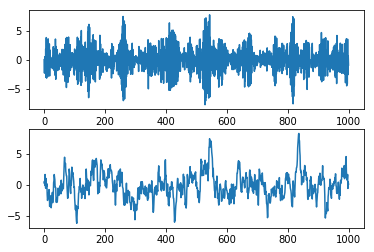

In [6]:
# length of AR(1) time-series
nsample = 1000

plt.figure(1)
# Plot 1: AR parameter = +0.9
plt.subplot(2,1,1)
ar1 = np.array([1, 0.9])
ma1 = np.array([1])
AR_object1 = ArmaProcess(ar1, ma1)
simulated_data_1 = AR_object1.generate_sample(nsample=nsample)
plt.plot(simulated_data_1)

# Plot 2: AR parameter = -0.9
plt.subplot(2,1,2)
ar2 = np.array([1, -0.9])
ma2 = np.array([1])
AR_object2 = ArmaProcess(ar2,ma2)
simulated_data_2 = AR_object2.generate_sample(nsample=nsample)
plt.plot(simulated_data_2)
plt.show()

## Plot Autocorrelation Functions and Calculate Optimal Block Length

### Simulated_1

<Figure size 432x288 with 0 Axes>

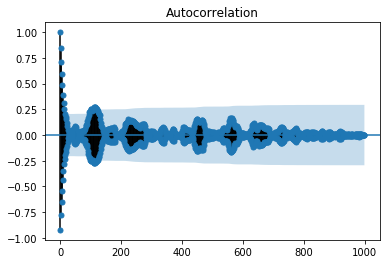

In [7]:
plt.figure(2)
plot_acf(simulated_data_1);

In [8]:
optimal_block_length(simulated_data_1)

(OptimalBlockLength(b_star_sb=95.0, b_star_cb=95.0),)

The first number is the optimal block length for a stationary bootstrap, while the second number refers to the optimal block length for the circular bootstrap.

### Simulated_2

<Figure size 432x288 with 0 Axes>

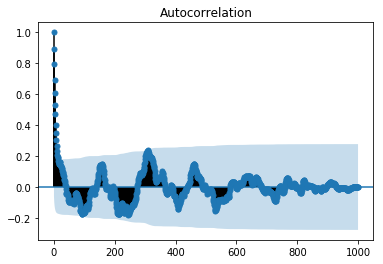

In [9]:
plt.figure(3)
plot_acf(simulated_data_2);

In [10]:
optimal_block_length(simulated_data_2)

(OptimalBlockLength(b_star_sb=42.00828233910472, b_star_cb=48.08747909877477),)

# Sample AR(1) Time-Series Data

To illustrate various block-based bootstrapping schemes, we generate a random time-series from an AR(1) process with autoregressive coefficient 0.5.

In [11]:
np.random.seed(1)

# number of time periods
T = 1000

# draw random errors
e = np.random.randn(T)
y = np.zeros((T,))

# y is an AR(1) with phi_1 = 0.5
phi_1 = 0.5
y[0] = e[0]*np.sqrt(1.0/(1.0-phi_1**2))
for t in range(1, T):
    y[t]=phi_1*y[t-1] + e[t]

# number of replications for bootstraps (number of sub-sampled time-series to generate)
B = 10000

### Optimal Block Length

<Figure size 432x288 with 0 Axes>

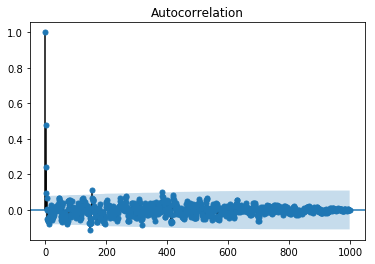

In [12]:
plt.figure(4)
plot_acf(y);

In [13]:
b_star = optimal_block_length(y)
b_star_sb = b_star[0].b_star_sb
b_star_cb = math.ceil(b_star[0].b_star_cb)
print(f'optimal block length for stationary bootstrap = {b_star_sb}')
print(f'optimal block length for circular bootstrap = {b_star_cb}')

optimal block length for stationary bootstrap = 10.384536321035092
optimal block length for circular bootstrap = 12


# Functions to Calculate the Number of Permutations of a Bootstrap

The number of possible combinations(when order does not matter) or permutations(when the order matters) of blocks decreases as the block length increases. Recombinator includes functions to compute the number of combinations and permutations that a certain situation affords.

In [14]:
from recombinator.utilities import calculate_number_of_blocks, number_of_combinations, number_of_permutations

In [15]:
number_of_blocks=calculate_number_of_blocks(sample_length=T, block_length=b_star_sb, overhang=False)
number_of_blocks

96

In [16]:
number_of_permutations(sub_sample_length=500, 
                       block_length=b_star_sb, 
                       number_of_blocks=number_of_blocks, 
                       replacement=False)

3834450179637570805626654744804085897192701932751876237985363307694044309618688000000000000

In [17]:
number_of_combinations(sub_sample_length=500, 
                       block_length=b_star_sb, 
                       number_of_blocks=number_of_blocks, 
                       replacement=False)

6303739115624129542943611200

# Block-Based Bootstrap Schemes

Recombinator includes the following three block-based bootstrapping schemes.
* Moving Block Bootstrap
* Circular Bootstrap
* Stationary Bootstrap
* Tapered Block Bootstrap

The algorithms allow samples to be generated which are shorter than the original data. This is called sub-sampling.

## Moving Block Bootstrap (Numba Implementation)

In [18]:
from recombinator.block_bootstrap import moving_block_bootstrap

## Moving Block Bootstrap (Vectorized Implementation)

In [19]:
from recombinator.block_bootstrap import moving_block_bootstrap_vectorized

In [20]:
y_star_mbv = moving_block_bootstrap_vectorized(y, 
                                               block_length=b_star_cb, 
                                               replications=B, 
                                               sub_sample_length=math.ceil(T/2))

In [21]:
y_star_mb = moving_block_bootstrap(y, 
                                   block_length=b_star_cb, 
                                   replications=B, 
                                   sub_sample_length=math.ceil(T/2), 
                                   replace=False)

In [22]:
# plt.plot(y_star[0, :])
# plt.show()

## Circular Block Bootstrap (Numba Implementation)

In [23]:
from recombinator.block_bootstrap import circular_block_bootstrap

## Circular Block Bootstrap (Vectorized Implementation)

In [24]:
from recombinator.block_bootstrap import circular_block_bootstrap_vectorized

## Stationary Bootstrap

In [25]:
from recombinator.block_bootstrap import stationary_bootstrap

In [26]:
y_star_sb = stationary_bootstrap(y, 
                                 block_length=b_star_sb, 
                                 replications=B, 
                                 sub_sample_length=math.ceil(T/2))

In [27]:
mu_star_mbv = np.mean(y_star_mbv, axis=1)
mu_star_mb = np.mean(y_star_mb, axis=1)
mu_star_sb = np.mean(y_star_sb, axis=1)
print(f'mean of moving block bootstrap vectorized = {np.mean(mu_star_mbv)}')
print(f'mean of moving block bootstrap with loops = {np.mean(mu_star_mb)}')
print(f'mean of stationary bootstrap              = {np.mean(mu_star_sb)}')

mean of moving block bootstrap vectorized = 0.08207300599843947
mean of moving block bootstrap with loops = 0.08215554030982396
mean of stationary bootstrap              = 0.07891111485442014


## Tapered Block Bootstrap (Numba Implementation)

In [28]:
from recombinator.tapered_block_bootstrap import tapered_block_bootstrap

## Tapered Block Bootstrap (Vectorized Implementation)

In [29]:
from recombinator.tapered_block_bootstrap import tapered_block_bootstrap_vectorized

# Monte-Carlo Study

In order to assess the ability of various bootstrapping schemes to preserve the temporal structure of the source data, we resample the AR(1) time-series a number of times and estimate the AR coefficient on each resampled time-series.

True AR coefficient of the original time-series:

In [30]:
phi_1

0.5

Estimated AR coefficient from the original time-series:

In [31]:
ar = AR(y)
estimate_from_original_data = ar.fit(maxlag=1)
print(estimate_from_original_data.params[1])

0.4780210270595022


Standard error of the estimated AR coefficient from the original time-series:

In [32]:
print(estimate_from_original_data.bse[1])

0.027772515735734964


## Estimate AR(1) Parameters From Time-Series Resampled Using a Circular Bootstrap

In [33]:
y_star_cb = circular_block_bootstrap(y, 
                                     block_length=b_star_cb, 
                                     replications=B, 
                                     replace=True)

In [34]:
# plt.plot(y_star_cb[0, :])
# plt.show()

In [35]:
estimates_from_bootstrap = []
ar_estimates_from_bootstrap = np.zeros((B, ))

for b in range(B):
    y_bootstrap = y_star_cb[b, :]
    ar_bootstrap = AR(y_bootstrap)
    estimate_from_bootstrap = ar_bootstrap.fit(maxlag=1)
    estimates_from_bootstrap.append(estimate_from_bootstrap)
    ar_estimates_from_bootstrap[b] = estimate_from_bootstrap.params[1]

mean=0.424059851278082
median=0.42480973929701793


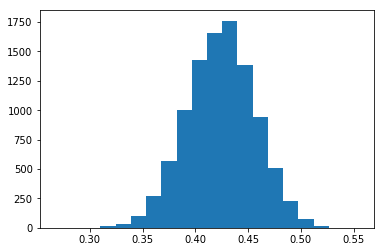

In [36]:
plt.hist(ar_estimates_from_bootstrap, bins=20)
print(f'mean={np.mean(ar_estimates_from_bootstrap)}')
print(f'median={np.median(ar_estimates_from_bootstrap)}')

## Estimate AR(1) Parameters From Time-Series Resampled Using a Moving Block Bootstrap

In [37]:
y_star_mb = moving_block_bootstrap(y, 
                                   block_length=b_star_cb, 
                                   replications=B, 
#                                    sub_sample_length=math.ceil(T/2), 
                                   replace=True)

In [38]:
estimates_from_bootstrap = []
ar_estimates_from_bootstrap = np.zeros((B, ))

for b in range(B):
    y_bootstrap = y_star_mb[b, :]
    ar_bootstrap = AR(y_bootstrap)
    estimate_from_bootstrap = ar_bootstrap.fit(maxlag=1)
    estimates_from_bootstrap.append(estimate_from_bootstrap)
    ar_estimates_from_bootstrap[b] = estimate_from_bootstrap.params[1]

mean=0.4292576010952751
median=0.429441358828349


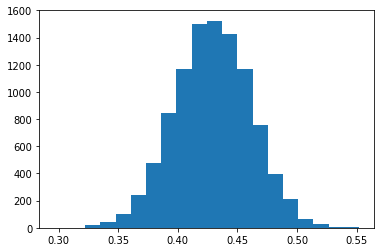

In [39]:
plt.hist(ar_estimates_from_bootstrap, bins=20)
print(f'mean={np.mean(ar_estimates_from_bootstrap)}')
print(f'median={np.median(ar_estimates_from_bootstrap)}')

## Estimate AR(1) Parameters From Time-Series Resampled Using a Stationary Bootstrap

In [40]:
y_star_sb = stationary_bootstrap(y, 
                                 block_length=b_star_sb, 
                                 replications=B, 
#                                  sub_sample_length=math.ceil(T/2)
                                )
y_star_sb.shape

(10000, 1000)

In [41]:
estimates_from_bootstrap = []
ar_estimates_from_bootstrap = np.zeros((B, ))

for b in range(B):
    y_bootstrap = y_star_sb[b, :]
    ar_bootstrap = AR(y_bootstrap)
    estimate_from_bootstrap = ar_bootstrap.fit(maxlag=1)
    estimates_from_bootstrap.append(estimate_from_bootstrap)
    ar_estimates_from_bootstrap[b] = estimate_from_bootstrap.params[1]

mean=0.429484119392432
median=0.4297873816693999


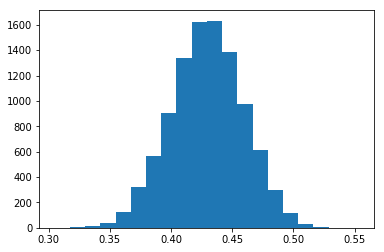

In [42]:
plt.hist(ar_estimates_from_bootstrap, bins=20)
print(f'mean={np.mean(ar_estimates_from_bootstrap)}')
print(f'median={np.median(ar_estimates_from_bootstrap)}')

## Estimate AR(1) Parameters From Time-Series Resampled Using a Tapered Block Bootstrap

In [43]:
y_star_tbb = tapered_block_bootstrap(y, 
                                     block_length=b_star_cb, 
                                     replications=B)
# y_star_tbb = tapered_block_bootstrap_vectorized(y, 
#                                                 block_length=b_star_cb, 
#                                                 replications=B)
y_star_tbb.shape

(10000, 1000)

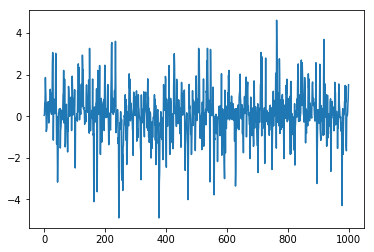

In [44]:
plt.plot(y_star_tbb[0, :])

In [45]:
estimates_from_bootstrap = []
ar_estimates_from_bootstrap = np.zeros((B, ))

for b in range(B):
    y_bootstrap = y_star_tbb[b, :]
    ar_bootstrap = AR(y_bootstrap)
    estimate_from_bootstrap = ar_bootstrap.fit(maxlag=1)
    estimates_from_bootstrap.append(estimate_from_bootstrap)
    ar_estimates_from_bootstrap[b] = estimate_from_bootstrap.params[1]

mean=0.46183487787021316
median=0.46239407374601216


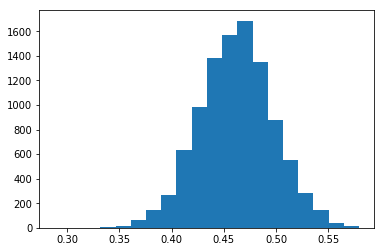

In [46]:
plt.hist(ar_estimates_from_bootstrap, bins=20)
print(f'mean={np.mean(ar_estimates_from_bootstrap)}')
print(f'median={np.median(ar_estimates_from_bootstrap)}')

# Performance Measurements

This section compares the runtime performance of various sub-sampling algorithms and implementations (Numba vs. vectorization)

### Stationary Bootstrap

In [47]:
%timeit stationary_bootstrap(y, block_length=b_star_sb, replications=B)

110 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
# %lprun -f stationary_bootstrap \
#           stationary_bootstrap(y, \
#                                block_length=b_star_sb, \
#                                replications=B)

### Moving Block Bootstrap (Numba Implementation)

In [49]:
%timeit moving_block_bootstrap(y, block_length=b_star_cb, replications=B)

55.2 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Circular Block Bootstrap (Numba Implementation)

In [50]:
%timeit circular_block_bootstrap(y, block_length=b_star_cb, replications=B)

55.3 ms ± 175 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Moving Block Bootstrap (Vectorized Implementation)

In [51]:
%timeit moving_block_bootstrap_vectorized(y, block_length=b_star_cb, replications=B)

69.8 ms ± 1.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
# %lprun -f moving_block_bootstrap_vectorized \
#           moving_block_bootstrap_vectorized(y, \
#                                             block_length=b_star_cb, \
#                                             replications=B)

### Circular Block Bootstrap (Vectorized Implementation)

In [53]:
%timeit circular_block_bootstrap_vectorized(y, block_length=b_star_cb, replications=B)

69.7 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
# %lprun -f circular_block_bootstrap_vectorized \
#           circular_block_bootstrap_vectorized(y, \
#                                               block_length=b_star_cb, \
#                                               replications=B)

### Tapered Block Bootstrap

In [55]:
%timeit tapered_block_bootstrap(y, block_length=b_star_cb, replications=B)

1.18 s ± 5.61 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
# %lprun -f tapered_block_bootstrap \
#           tapered_block_bootstrap(y, block_length=b_star_cb, replications=B)

### Tapered Block Bootstrap (Vectorized Implementation)

In [57]:
%timeit tapered_block_bootstrap_vectorized(y, block_length=b_star_cb, replications=B)

89.8 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
# %lprun -f tapered_block_bootstrap_vectorized \
#           tapered_block_bootstrap_vectorized(y, block_length=b_star_cb, replications=B)

# References

CARLSTEIN, E., DO, K.-A., HALL, P., HESTERBERG, T. and KUENSCH, H. (1998). Matched-block boot-strap for dependent data. Bernoulli 4, 305-328.

KUENSCH, H. (1989). The jackknife and the bootstrap for general stationary observations. Ann. Statist. 17, 1217-41.

PAPARODITIS, E. and POLITIS, D. N. (2001). Tapered block bootstrap. Biometrika 88, 1105-1119.

POLITIS, D. N. & ROMANO, J. P. (1992). A circular block-resampling procedure for stationary data. In Exploring the Limits of Bootstrap, Ed. R. LePage and L. Billard, pp. 263-70. New York: John Wiley.

POLITIS, D. N. & ROMANO, J. P. (1994). The stationary bootstrap. J. Am. Statist. Assoc. 89, 1303-13.

SHAO, XIAOFENG (2010). Extended Tapered Block Bootstrap. Statistica Sinica, 20(2), 807-821.

SHAO, XIAOFENG (2012) The Dependent Wild Bootstrap, Journal of the American Statistical Association, 105:489, 218-235